In [9]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load images, labels, masks

In [10]:
NPY_PATH = r"dataset\numpy"

labels = np.load(os.path.join(NPY_PATH,'labels.npy'))
# t1w_images = (np.load(os.path.join(NPY_PATH,'T1W_images.npy')) / 255.0).astype(np.float32)
t2f_images = (np.load(os.path.join(NPY_PATH,'T2F_images.npy')) / 255.0).astype(np.float32)
t2w_images = (np.load(os.path.join(NPY_PATH,'T2W_images.npy')) / 255.0).astype(np.float32)
masks = (np.load(os.path.join(NPY_PATH,'Mask_images.npy')) / 255.0).astype(np.float32)

print(masks.shape)

(2356, 260, 320)


In [11]:
# 모델의 입력 형태에 맞추기 위해 차원을 확장합니다.
# example. (,260,320) -> (,260,320,1)
# t1w_images = np.expand_dims(t1w_images,axis=-1)
t2f_images = np.expand_dims(t2f_images,axis=-1)
t2w_images = np.expand_dims(t2w_images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

# Resizing

In [12]:
from util import downsample

img_size_ori = (260,320)
img_size_target = (256,256)

# t1w_images = np.array([ downsample(image,img_size_ori,img_size_target) for image in t1w_images ])
t2f_images = np.array([ downsample(image,img_size_ori,img_size_target) for image in t2f_images ])
t2w_images = np.array([ downsample(image,img_size_ori,img_size_target) for image in t2w_images ])
masks = (np.array([ downsample(mask,img_size_ori,img_size_target) for mask in masks ])>0)*1.0

# Train & Test Split

In [13]:
from sklearn.model_selection import train_test_split
import gc

image_datasets = np.concatenate((t2f_images,t2w_images),axis=0)
mask_datasets = np.concatenate((masks,masks),axis =0)
labels_datasets = np.concatenate((labels,labels),axis =0)

X,X_v,Y,Y_v = train_test_split( image_datasets,mask_datasets,test_size=0.2,stratify=labels_datasets,random_state=444, shuffle=True)

del t2f_images
del t2w_images
del masks
del labels

del image_datasets
del mask_datasets
del labels_datasets

gc.collect()

158098

<Figure size 720x576 with 0 Axes>

<Figure size 576x6480 with 0 Axes>

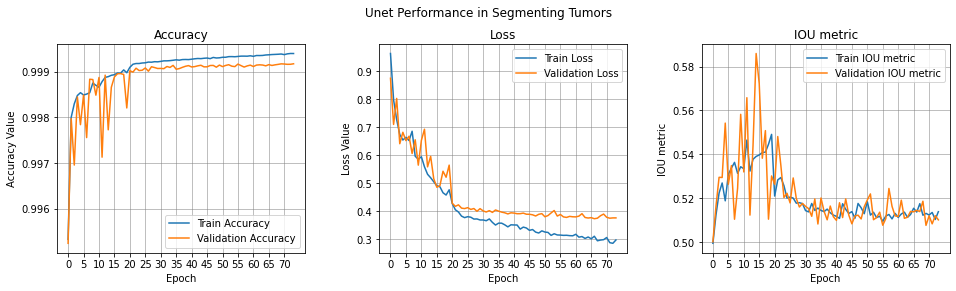

In [14]:
from model import baseModel, unet_v1, unet_v2, unet_v3, unet_v5
from util import bce_dice_loss, historyToJson, historyToPng, getIOUCurve
from keras.metrics import MeanIoU
from keras.models import load_model
import json
import numpy as np
from numpyEncoder import NumpyEncoder

model_options = [
	{
		'model_name': 'base_256_without_t1w',
		'model' : baseModel,
		'input_shape' : (256,256,1)
	}
]

for model_option in model_options:
 
    model_name = model_option['model_name']
    model = model_option['model']
    input_shape = model_option['input_shape']

    CHECKPOINT_NAME = f'model_{model_name}_best_checkpoint.h5'
    HISTORY_PATH = f'document/model_{model_name}_history.json'
    HISTORY_PNG_PATH = f'document/model_{model_name}_history.png'
    BEST_THRESHOLD_PNG_PATH = f'document/model_{model_name}_best_threshold.png'
    PREDICTION_IMAGE = f'document/model_{model_name}_prediction.png'

    unet = model(input_shape=input_shape)
    unet = load_model(CHECKPOINT_NAME, custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':MeanIoU(num_classes=2,name="mean_iou")})

    f, (ax1) = plt.subplots(1,1, figsize=(10, 8))
    t = f.suptitle('Unet Performance \n Threshold vs IoU', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    # th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
    # ax2.plot(th, ious,label="For Train")
    # ax2.plot(th_best, iou_best, "xr", label="Best threshold")
    # ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
    # ax2.set_title("threshold : {}\niou : {}".format(th_best, iou_best))

    th, ious, iou_best, th_best = getIOUCurve(Y_v,unet.predict(X_v))
    ax1.plot(th, ious,label="For Validation")
    ax1.plot(th_best, iou_best, "xr", label="Best threshold")
    ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
    ax1.set_title("threshold : {}\niou : {}".format(th_best, iou_best))

    plt.savefig(BEST_THRESHOLD_PNG_PATH)
    plt.clf()

    predicted_mask = (unet.predict(X_v)>(th_best))*1

    i=1;total=30
    temp = np.ones_like( Y_v[0] )

    plt.figure(figsize=(8,90))
    # for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    for idx in range(120,120+total):
        plt.subplot(total,3,i);i+=1
        plt.imshow(X_v[idx], cmap='gray' )
        plt.title("MRI Image");plt.axis('off')
        
        plt.subplot(total,3,i);i+=1
        plt.imshow( X_v[idx], cmap='gray' )
        plt.imshow( Y_v[idx], alpha=0.8, cmap='Reds' )
        plt.title("Original Mask");plt.axis('off')
        
        plt.subplot(total,3,i);i+=1
        plt.imshow( X_v[idx], cmap='gray' )
        plt.imshow( predicted_mask[idx],  alpha=0.8, cmap='Reds' )
        plt.title("Predicted Mask");plt.axis('off')

    plt.savefig(PREDICTION_IMAGE)
    plt.clf()

    with open(HISTORY_PATH,'r') as json_file:
        json_data = json.load(json_file)
        historyToPng(json_data,HISTORY_PNG_PATH)

In [15]:
# from model import baseModel, unet_v1, unet_v2, unet_v3
# from util import bce_dice_loss, historyToJson, historyToPng, getIOUCurve
# from keras.metrics import MeanIoU
# from keras.models import load_model
# import json
# import numpy as np
# from numpyEncoder import NumpyEncoder

# model_list = baseModel
# model_name = 'base_256'
# model_input_shape = (256,256,1)

# CHECKPOINT_NAME = f'model_{model_name}_best_checkpoint.h5'
# HISTORY_PATH = f'model_{model_name}_history.json'
# HISTORY_PNG_PATH = f'document/model_{model_name}_history.png'
# BEST_THRESHOLD_PNG_PATH = f'document/model_{model_name}_best_threshold.png'
# PREDICTION_IMAGE = f'document/model_{model_name}_prediction.png'

# unet = model_list(input_shape=model_input_shape)
# unet = load_model(CHECKPOINT_NAME, custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':MeanIoU(num_classes=2,name="mean_iou")})

# f, (ax1) = plt.subplots(1,1, figsize=(10, 8))
# t = f.suptitle('Unet Performance \n Threshold vs IoU', fontsize=12)
# f.subplots_adjust(top=0.85, wspace=0.3)

# # th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
# # ax2.plot(th, ious,label="For Train")
# # ax2.plot(th_best, iou_best, "xr", label="Best threshold")
# # ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
# # ax2.set_title("threshold : {}\niou : {}".format(th_best, iou_best))

# th, ious, iou_best, th_best = getIOUCurve(Y_v,unet.predict(X_v))
# ax1.plot(th, ious,label="For Validation")
# ax1.plot(th_best, iou_best, "xr", label="Best threshold")
# ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
# ax1.set_title("threshold : {}\niou : {}".format(th_best, iou_best))

# plt.savefig(BEST_THRESHOLD_PNG_PATH)
# plt.clf()

# predicted_mask = (unet.predict(X_v)>(th_best))*1

# i=1;total=30
# temp = np.ones_like( Y_v[0] )

# plt.figure(figsize=(8,90))
# # for idx in np.random.randint(0,high=X_v.shape[0],size=total):
# for idx in range(120,120+total):
#     plt.subplot(total,3,i);i+=1
#     plt.imshow(X_v[idx], cmap='gray' )
#     plt.title("MRI Image");plt.axis('off')
    
#     plt.subplot(total,3,i);i+=1
#     plt.imshow( X_v[idx], cmap='gray' )
#     plt.imshow( Y_v[idx], alpha=0.8, cmap='Reds' )
#     plt.title("Original Mask");plt.axis('off')
    
#     plt.subplot(total,3,i);i+=1
#     plt.imshow( X_v[idx], cmap='gray' )
#     plt.imshow( predicted_mask[idx],  alpha=0.8, cmap='Reds' )
#     plt.title("Predicted Mask");plt.axis('off')

# plt.savefig(PREDICTION_IMAGE)
# plt.clf()

# with open(HISTORY_PATH,'r') as json_file:
#     json_data = json.load(json_file)
#     historyToPng(json_data,HISTORY_PNG_PATH)

In [16]:
# import os

# # The notifier function
# def notify(title, subtitle, message):
#     t = '-title {!r}'.format(title)
#     s = '-subtitle {!r}'.format(subtitle)
#     m = '-message {!r}'.format(message)
#     os.system('terminal-notifier {}'.format(' '.join([m, t, s])))

# # Calling the function
# notify(title    = 'Unet evaluate done',
#        subtitle = 'with jupyter',
#        message  = '')